In [1]:
import numpy as np
from minisom import MiniSom
from neupy.algorithms import SOFM, LVQ
import neurolab as nl
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

/Users/linuxoid/.virtualenvs/dl4cv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/linuxoid/.virtualenvs/dl4cv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/linuxoid/.virtualenvs/dl4cv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/linuxoid/.virtualenvs/dl4cv/lib/python3

Сформируем множество точек, которые изначально сгруппированы в 8 кластеров

In [2]:
x, y, centers = make_blobs(n_samples=80, cluster_std=0.1, n_features=2, centers=8, center_box=(0, 1.5), return_centers=True, random_state=177)

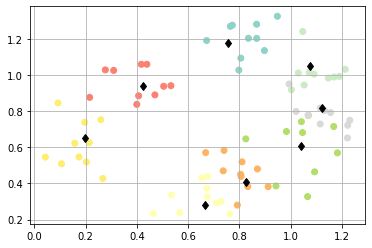

In [3]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='Set3')
plt.plot(centers[:,0], centers[:, 1], 'dk')
plt.grid(True)

Построим и обучим слой Кохонена

In [4]:
clusters = 8
competNet = nl.net.newc([[0.0, 0.8],[0.0, 1.3]], clusters)
error = competNet.train(x, epochs=500, show=100)

Epoch: 100; Error: 11.665465139412095;
Epoch: 200; Error: 10.851547969874245;
Epoch: 300; Error: 10.830853273825525;
Epoch: 400; Error: 10.821346075947165;
Epoch: 500; Error: 10.830191716124164;
The maximum number of train epochs is reached


Весовые коэффициенты первого слоя, которые являются центрами кластеров.

In [5]:
weightsAreCenter = competNet.layers[0].np['w']
weightsAreCenter

array([[0.84832099, 1.20155109],
       [1.09172001, 0.95555503],
       [0.16919963, 0.62326102],
       [0.38765654, 0.95363924],
       [1.13595554, 0.74165526],
       [0.76041217, 0.51485745],
       [0.66193061, 0.30223818],
       [1.01284502, 0.48882437]])

Text(0, 0.5, 'Error (default MAE)')

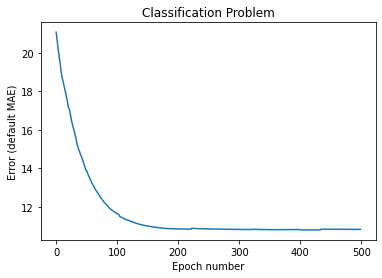

In [6]:
plt.title('Classification Problem')
plt.plot(error)
plt.xlabel('Epoch number')
plt.ylabel('Error (default MAE)')

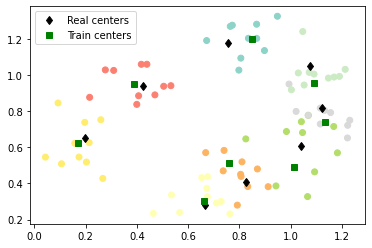

In [7]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='Set3')
plt.plot(centers[:,0], centers[:, 1], 'dk')
plt.plot(weightsAreCenter[:,0], weightsAreCenter[:,1], 'gs')
plt.legend(['Real centers', 'Train centers'])
plt.show()

Проверим качество разбиения. Создадим случайным образом 5 точек

In [8]:
randPoints = np.array([[np.random.uniform(0, 1.5),
                        np.random.uniform(0, 1.5)] for _ in range(5)])

Подаем их в сеть и на выходе получим номера кластеров

In [9]:
pred = competNet.sim(randPoints)

Таким образом пять точек принадлежат следующим классам

In [10]:
classPred = np.argmax(pred, axis=1)

classPred

array([3, 2, 2, 1, 6])

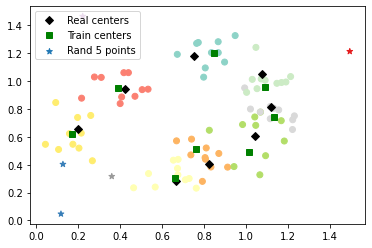

In [11]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='Set3')
plt.plot(centers[:,0], centers[:, 1], 'Dk', label='Real centers')
plt.plot(weightsAreCenter[:,0], weightsAreCenter[:,1], 'gs', label='Train centers')
plt.scatter(randPoints[:, 0], randPoints[:, 1], c=classPred,
            cmap='Set1', marker='*', label='Rand 5 points')
plt.legend()
plt.show()

Задание 2

Нужно построить и обучить карту Кохонена размера 2x4 с гексагональной сеткой

In [12]:
x2, y2 = make_blobs(n_samples=80, cluster_std=0.1, n_features=2,
                    centers=8, center_box=(0, 1.5), random_state=91)

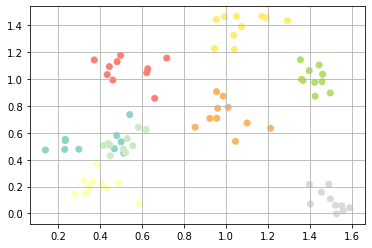

In [13]:
plt.scatter(x2[:, 0], x2[:, 1], c=y2, cmap='Set3')
plt.grid(True)

In [14]:
epochs = 150
som = MiniSom(2, 4, x2.shape[1], sigma=0.66, learning_rate=0.8, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)
som.train(x2, epochs, verbose=True)

 [ 150 / 150 ] 100% - 0:00:00 left 
 quantization error: 0.12410940670780753


In [15]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

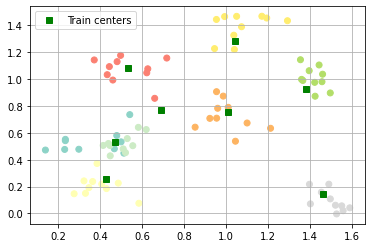

In [16]:
plt.scatter(x2[:, 0], x2[:, 1], c=y2, cmap='Set3')
plt.plot(weights[0][:,0], weights[0][:,1], 'gs', label='Train centers')
plt.plot(weights[1][:,0], weights[1][:,1], 'gs')
plt.legend()
plt.grid(True)

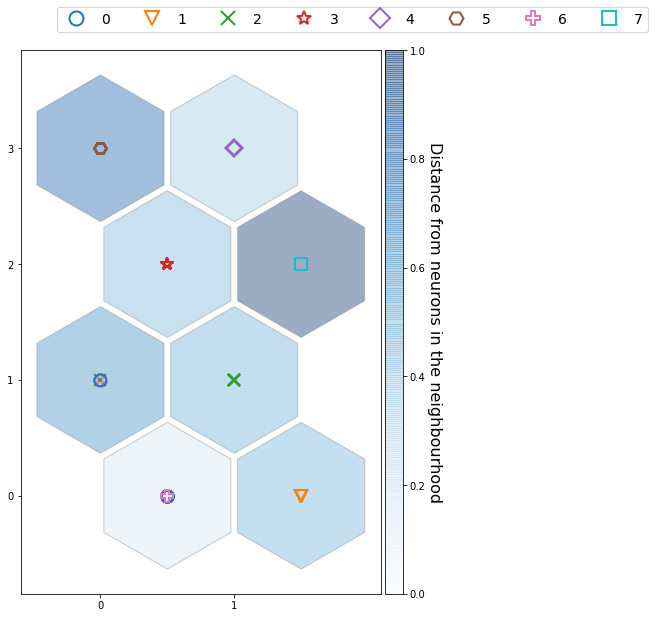

In [17]:
def DrawHex(x2, y2, xx, yy, umatrix, weights):    
    f = plt.figure(figsize=(10,10))
    ax = f.add_subplot(111)

    ax.set_aspect('equal')

    # iteratively add hexagons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            wy = yy[(i, j)] * 2 / np.sqrt(3) * 3 / 4
            hex = RegularPolygon((xx[(i, j)], wy), 
                                 numVertices=6, 
                                 radius=0.95 / np.sqrt(3),
                                 facecolor=cm.Blues(umatrix[i, j]), 
                                 alpha=0.4, 
                                 edgecolor='gray')
            ax.add_patch(hex)

    markers = ['o', 'v', 'x', '*', 'D', 'H', 'P', 's']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan']
    for cnt, x in enumerate(x2):
        # getting the winner
        w = som.winner(x)
        # place a marker on the winning position for the sample xx
        wx, wy = som.convert_map_to_euclidean(w) 
        wy = wy * 2 / np.sqrt(3) * 3 / 4
        plt.plot(wx, wy, 
                 markers[y2[cnt]], 
                 markerfacecolor='None',
                 markeredgecolor=colors[y2[cnt]], 
                 markersize=12, 
                 markeredgewidth=2)

    xrange = np.arange(weights.shape[0])
    yrange = np.arange(weights.shape[1])
    plt.xticks(xrange-0.5, xrange)
    plt.yticks(yrange * 2 / np.sqrt(3) * 3 / 4, yrange)

    divider = make_axes_locatable(plt.gca())
    ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
    cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                                orientation='vertical', alpha=.4)
    cb1.ax.get_yaxis().labelpad = 16
    cb1.ax.set_ylabel('Distance from neurons in the neighbourhood',
                      rotation=270, fontsize=16)
    plt.gcf().add_axes(ax_cb)

    legend_elements = [Line2D([0], [0], marker='o', color='tab:blue', label='0',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='v', color='tab:orange', label='1',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='x', color='tab:green', label='2',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='*', color='tab:red', label='3',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='D', color='tab:purple', label='4',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='H', color='tab:brown', label='5',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='P', color='tab:pink', label='6',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                       Line2D([0], [0], marker='s', color='tab:cyan', label='7',
                       markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left', 
              borderaxespad=0., ncol=8, fontsize=14)
    plt.show()
    
DrawHex(x2, y2, xx, yy, umatrix, weights)

In [18]:
randx, randy = make_blobs(n_samples=5, cluster_std=0.1, n_features=2,
                    centers=8, center_box=(0, 1.5), random_state=91)

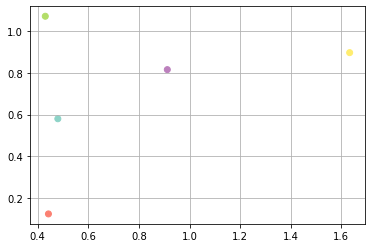

In [19]:
plt.scatter(randx[:, 0], randx[:, 1], c=randy, cmap='Set3')
plt.grid(True)

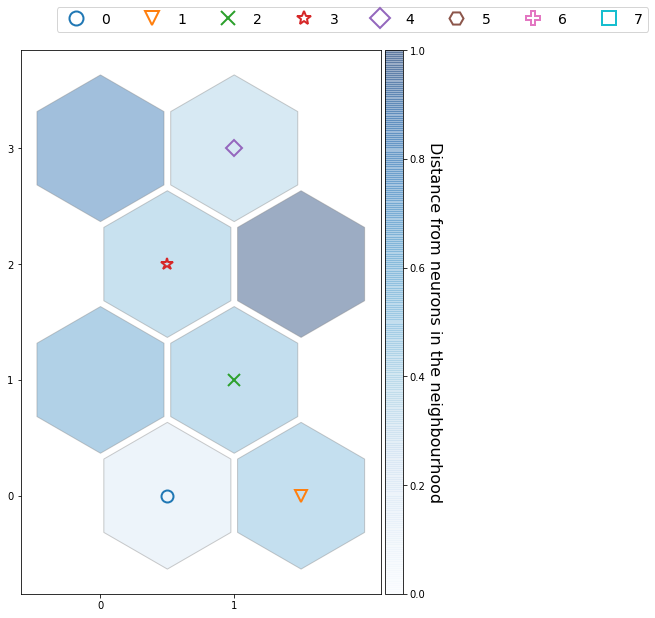

In [20]:
DrawHex(randx, randy, xx, yy, umatrix, weights)

Задание 3

Построим и обучим карту Кохонена, которая будет находить одно из решений задачи коммивояжера.

Сгенерируем набор из 20 случайных точек из диапазона [-1.5, 1.5].

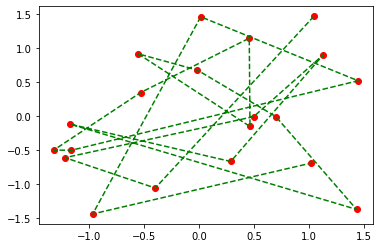

In [21]:
z = np.array([[np.random.uniform(-1.5, 1.5), np.random.uniform(-1.5, 1.5)] for _ in range(20)])
plt.plot(z[:, 0], z[:, 1], '--', c='green')
plt.scatter(z[:, 0], z[:, 1], c='red');

In [22]:
np.random.RandomState(10)
neurons = 80

som = MiniSom(1, neurons, z.shape[1], sigma=8, learning_rate=0.4,
              neighborhood_function='gaussian', random_seed=0)
som.random_weights_init(z)

/Users/linuxoid/.virtualenvs/dl4cv/lib/python3.7/site-packages/minisom.py:154: UserWarning: Warning: sigma is too high for the dimension of the map.
  warn('Warning: sigma is too high for the dimension of the map.')


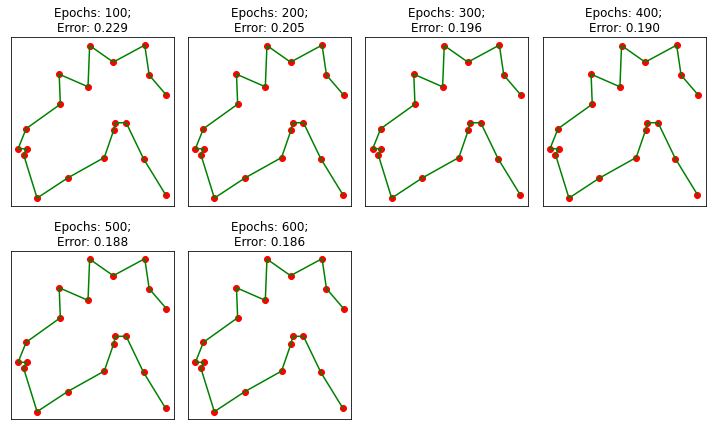

In [32]:
plt.figure(figsize=(10, 9))
for i, iterations in enumerate(range(100, 601, 100)):
    som.train(z, iterations, verbose=False, random_order=False)
    plt.subplot(3, 4, i+1)
    plt.scatter(z[:, 0], z[:, 1], c='red')
    visit_order = np.argsort([som.winner(p)[1] for p in z])
    #visit_order = np.concatenate((visit_order, [visit_order[0]]))
    plt.plot(z[visit_order][:,0], z[visit_order][:,1], c='green')
    plt.title("Epochs: {i};\nError: {e:.3f}".format(i=iterations, 
                                                    e=som.quantization_error(z)))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

4 задание

Для обучающей выборки построить LVQ-сеть, которая будет правильно соотносить точки к двум классам. Классы не являются линейно разделимыми.

In [24]:
points = np.array([[1.2, -1.3, -0.5, -1.1, -1.2, -0.1, 0.6, 1.1, 0.5, -1.5, 0, 1.2],
                  [0.8, -0.8, 0.5, 0.6, 0.4, 0.8, 1.2, -0.5, -1, 0.7, -0.1, 0.3]])
target = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
pointsT = points.T

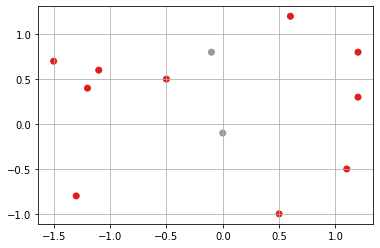

In [25]:
plt.scatter(pointsT[:, 0], pointsT[:, 1], c=target, cmap='Set1')
plt.grid(True)

Строим LVQ-сеть и обучаем на 300 эпохах.

In [26]:
lvqnet = LVQ(n_inputs=2, n_classes=2, step=0.1)
lvqnet.train(pointsT, target, epochs=300)

Проверяем качество обучения.

Для этого классифицируем точки области [-1.5;1.5]x[-1.5;1.5] с шагом 0.1

In [27]:
xx, yy = np.meshgrid(np.arange(-1.5, 1.51, 0.1), np.arange(-1.5, 1.51, 0.1))
xx.shape = xx.size, 1
yy.shape = yy.size, 1
sample = np.concatenate((xx, yy), axis=1)

Рассчитаем выходы сети

In [28]:
pred = lvqnet.predict(sample)

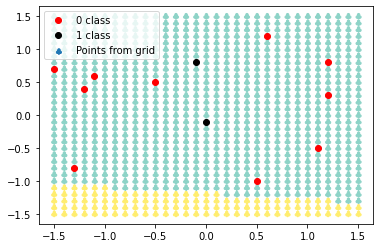

In [29]:
plt.scatter(sample[:, 0], sample[:, 1], c=pred,
            cmap='Set3', marker=r'$\clubsuit$', label='Points from grid')
plt.plot([pointsT[i][0] for i in range(12) if target[i] == 0], 
         [pointsT[i][1] for i in range(12) if target[i] == 0], 'ro', label='0 class')
plt.plot([pointsT[i][0] for i in range(12) if target[i] == 1], 
         [pointsT[i][1] for i in range(12) if target[i] == 1], 'ko', label='1 class');
plt.legend()
plt.show()